In [40]:
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("../data")
all_batches = []

for batch_dir in sorted(DATA_ROOT.glob("batch_*")):
    data_path = batch_dir / "WristMotion.csv"
    label_path = batch_dir / "Annotation.csv"

    # Load
    data = pd.read_csv(data_path).sort_values("time")
    labels = pd.read_csv(label_path).sort_values("time")

    # Map labels
    labels["label"] = labels["text"].map({"no": 0, "yes": 1})

    # Merge (state-based labeling)
    aligned = pd.merge_asof(
        data, labels[["time", "label"]], on="time", direction="backward"
    )

    # Drop rows before first label
    aligned = aligned.dropna(subset=["label"])
    aligned["label"] = aligned["label"].astype(int)

    # Optional but highly recommended
    aligned["batch_id"] = batch_dir.name

    all_batches.append(aligned)

# Concatenate all batches
final_df = pd.concat(all_batches, ignore_index=True)

# Final sort (safety)
final_df = final_df.sort_values("time").reset_index(drop=True)

aligned = final_df


In [41]:
# import pandas as pd


# data = pd.read_csv("../data/Lakemont_Bend_Ln-2025-12-26_17-57-04/WristMotion.csv")
# labels = pd.read_csv("../data/Lakemont_Bend_Ln-2025-12-26_17-57-04/Annotation.csv")

# # Sort by time
# labels = labels.sort_values("time")
# data = data.sort_values("time")

# # Map labels
# labels["label"] = labels["text"].map({"no": 0, "yes": 1})

# # Merge using "last known label"
# aligned = pd.merge_asof(
#     data, labels[["time", "label"]], on="time", direction="backward"
# )
# # Drop rows before first label
# aligned = aligned.dropna(subset=["label"])
# aligned.head()


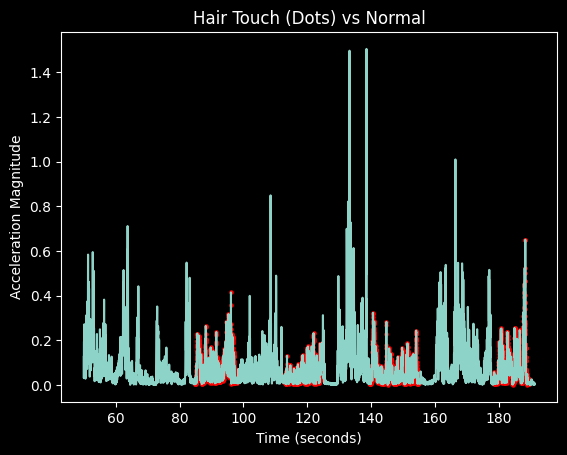

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(aligned["seconds_elapsed"], aligned["accelerationMagnitude"])
plt.scatter(
    aligned[aligned["label"] == 1]["seconds_elapsed"],
    aligned[aligned["label"] == 1]["accelerationMagnitude"],
    s=5,
    color="red",
)
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration Magnitude")
plt.title("Hair Touch (Dots) vs Normal")
plt.show()


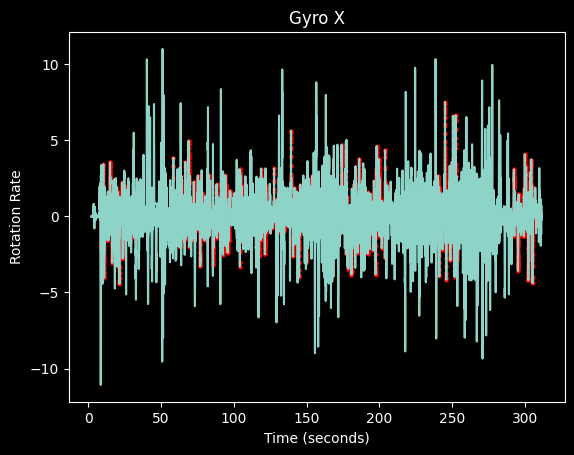

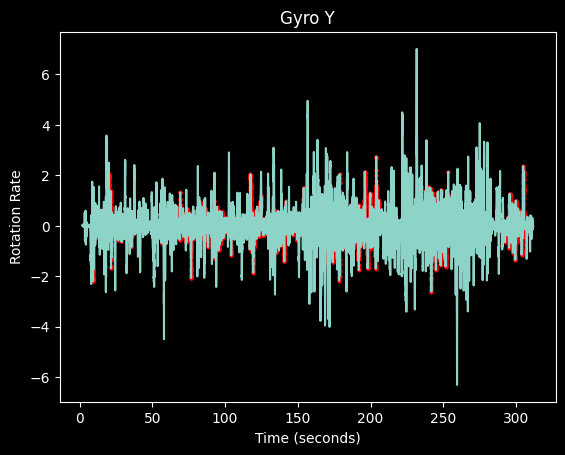

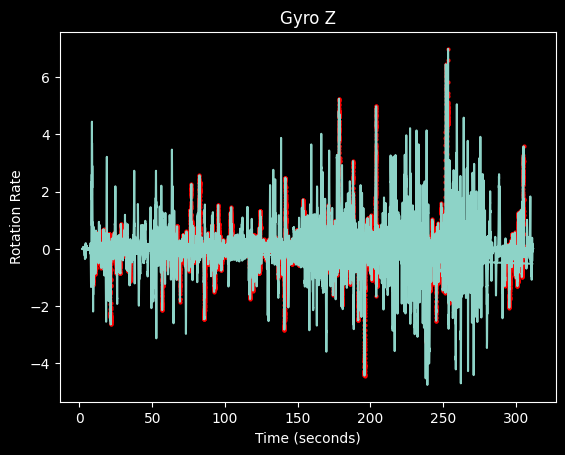

In [43]:
for axis in ["X", "Y", "Z"]:
    plt.figure()
    plt.plot(aligned["seconds_elapsed"], aligned[f"rotationRate{axis}"])

    # Filter the data for the specific condition
    condition_data = aligned[aligned["label"] == 1]

    # Set the color for the specific condition
    condition_color = "red"

    # Plot the data for the specific condition with the specified color
    plt.scatter(
        condition_data["seconds_elapsed"],
        condition_data[f"rotationRate{axis}"],
        s=4,
        color=condition_color,
    )

    plt.title(f"Gyro {axis}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Rotation Rate")
    plt.show()

In [44]:
import numpy as np

FEATURES = [
    "accelerationX",
    "accelerationY",
    "accelerationZ",
    "rotationRateX",
    "rotationRateY",
    "rotationRateZ",
    "accelerationMagnitude",
]

WINDOW_SIZE = 400  # 2 seconds
STEP_SIZE = 100  # 1 second overlap

X = []
y = []

for start in range(0, len(aligned) - WINDOW_SIZE, STEP_SIZE):
    window = aligned.iloc[start : start + WINDOW_SIZE]

    # Majority vote label
    label = int(window["label"].mean() >= 0.5)

    X.append(window[FEATURES].values)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


(847, 400, 7) (847,)


In [45]:
def extract_features(X):
    feats = []
    for window in X:
        means = window.mean(axis=0)
        stds = window.std(axis=0)
        feats.append(np.concatenate([means, stds]))
    return np.array(feats)


X_feat = extract_features(X)

print(X_feat.shape)


(847, 14)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.25, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=200, max_depth=8, class_weight="balanced", random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.93      0.96       151
           1       0.85      0.95      0.90        61

    accuracy                           0.94       212
   macro avg       0.92      0.94      0.93       212
weighted avg       0.94      0.94      0.94       212



In [31]:
importances = model.feature_importances_
feature_names = [f"{f}_mean" for f in FEATURES] + [f"{f}_std" for f in FEATURES]

for name, val in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {val:.3f}")


accelerationX_mean: 0.141
accelerationZ_std: 0.127
accelerationY_std: 0.118
rotationRateX_std: 0.117
accelerationX_std: 0.109
accelerationZ_mean: 0.072
rotationRateY_std: 0.070
rotationRateZ_std: 0.066
rotationRateZ_mean: 0.058
rotationRateX_mean: 0.033
accelerationY_mean: 0.029
rotationRateY_mean: 0.028
accelerationMagnitude_std: 0.021
accelerationMagnitude_mean: 0.010
